In [2]:
from __future__ import absolute_import, division, print_function

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.VERSION)

AUTOTUNE = tf.data.experimental.AUTOTUNE

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
plt.interactive(False)

from pathlib import *

data_root = Path('/home/charles/Downloads/dataset5/A')

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root))


1.13.1


Found 12553 images belonging to 24 classes.


In [3]:
classifier_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/2" #@param {type:"string"}

import tensorflow_hub as hub
from tensorflow.keras import layers


def classifier(x):
  classifier_module = hub.Module(classifier_url)
  return classifier_module(x)
  
IMAGE_SIZE = hub.get_expected_image_size(hub.Module(classifier_url))

classifier_layer = layers.Lambda(classifier, input_shape = IMAGE_SIZE+[3])
classifier_model = tf.keras.Sequential([classifier_layer])
classifier_model.summary()

image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SIZE)
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

W0309 22:45:24.391773 140518042297856 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


Instructions for updating:
Colocations handled automatically by placer.


W0309 22:45:25.120533 140518042297856 deprecation.py:323] From /home/charles/TF/venv/lib/python3.7/site-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0309 22:45:29.896949 140518042297856 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1001)              0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


Found 12553 images belonging to 24 classes.


Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 24)


In [4]:
import tensorflow.keras.backend as K
sess = K.get_session()
init = tf.global_variables_initializer()

sess.run(init)

In [5]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2" #@param {type:"string"}

def feature_extractor(x):
  feature_extractor_module = hub.Module(feature_extractor_url)
  return feature_extractor_module(x)

IMAGE_SIZE = hub.get_expected_image_size(hub.Module(feature_extractor_url))

features_extractor_layer = layers.Lambda(feature_extractor, input_shape=IMAGE_SIZE+[3])
features_extractor_layer.trainable = False


In [6]:
model = tf.keras.Sequential([
  features_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0309 22:45:48.235649 140518042297856 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 24)                30744     
Total params: 30,744
Trainable params: 30,744
Non-trainable params: 0
_________________________________________________________________


In [7]:
init = tf.global_variables_initializer()
sess.run(init)
result = model.predict(image_batch)
result.shape

(32, 24)

In [22]:
from tensorflow.keras import optimizers
model.compile(
  optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []
    
  def on_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])

steps_per_epoch = image_data.samples//image_data.batch_size
batch_stats = CollectBatchStats()
model.fit((item for item in image_data), epochs=1, 
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats])


  1/392 [..............................] - ETA: 12:01 - loss: 0.1671 - acc: 1.0000

  2/392 [..............................] - ETA: 9:21 - loss: 0.1651 - acc: 0.9844 

  3/392 [..............................] - ETA: 8:26 - loss: 0.2256 - acc: 0.9688

  4/392 [..............................] - ETA: 7:55 - loss: 0.2362 - acc: 0.9609

  5/392 [..............................] - ETA: 7:33 - loss: 0.2257 - acc: 0.9500

  6/392 [..............................] - ETA: 7:20 - loss: 0.2215 - acc: 0.9479

  7/392 [..............................] - ETA: 7:13 - loss: 0.2197 - acc: 0.9509

  8/392 [..............................] - ETA: 7:03 - loss: 0.2128 - acc: 0.9531

  9/392 [..............................] - ETA: 6:55 - loss: 0.2262 - acc: 0.9479

 10/392 [..............................] - ETA: 6:49 - loss: 0.2177 - acc: 0.9500

 11/392 [..............................] - ETA: 6:43 - loss: 0.2185 - acc: 0.9517

 12/392 [..............................] - ETA: 6:40 - loss: 0.2119 - acc: 0.9531

 13/392 [..............................] - ETA: 6:38 - loss: 0.2040 - acc: 0.9543

 14/392 [>.............................] - ETA: 6:34 - loss: 0.2030 - acc: 0.9554

 15/392 [>.............................] - ETA: 6:30 - loss: 0.1975 - acc: 0.9563

 16/392 [>.............................] - ETA: 6:27 - loss: 0.1925 - acc: 0.9570

 17/392 [>.............................] - ETA: 6:24 - loss: 0.1924 - acc: 0.9577

 18/392 [>.............................] - ETA: 6:21 - loss: 0.1980 - acc: 0.9549

 19/392 [>.............................] - ETA: 6:19 - loss: 0.1947 - acc: 0.9556

 20/392 [>.............................] - ETA: 6:17 - loss: 0.1972 - acc: 0.9547

 21/392 [>.............................] - ETA: 6:15 - loss: 0.1999 - acc: 0.9539

 22/392 [>.............................] - ETA: 6:14 - loss: 0.2040 - acc: 0.9531

 23/392 [>.............................] - ETA: 6:12 - loss: 0.2038 - acc: 0.9538

 24/392 [>.............................] - ETA: 6:10 - loss: 0.1997 - acc: 0.9544

 25/392 [>.............................] - ETA: 6:09 - loss: 0.1993 - acc: 0.9538

 26/392 [>.............................] - ETA: 6:08 - loss: 0.2039 - acc: 0.9531

 27/392 [=>............................] - ETA: 6:06 - loss: 0.2099 - acc: 0.9502

 28/392 [=>............................] - ETA: 6:05 - loss: 0.2057 - acc: 0.9509

 29/392 [=>............................] - ETA: 6:03 - loss: 0.2026 - acc: 0.9526

 30/392 [=>............................] - ETA: 6:02 - loss: 0.2021 - acc: 0.9521

 31/392 [=>............................] - ETA: 6:00 - loss: 0.2008 - acc: 0.9526

 32/392 [=>............................] - ETA: 5:59 - loss: 0.1991 - acc: 0.9521

 33/392 [=>............................] - ETA: 5:58 - loss: 0.2011 - acc: 0.9517

 34/392 [=>............................] - ETA: 5:56 - loss: 0.1998 - acc: 0.9522

 35/392 [=>............................] - ETA: 5:54 - loss: 0.1984 - acc: 0.9536

 36/392 [=>............................] - ETA: 5:53 - loss: 0.1984 - acc: 0.9540

 37/392 [=>............................] - ETA: 5:52 - loss: 0.1965 - acc: 0.9544

 38/392 [=>............................] - ETA: 5:51 - loss: 0.1983 - acc: 0.9531

 39/392 [=>............................] - ETA: 5:49 - loss: 0.2011 - acc: 0.9519

 40/392 [==>...........................] - ETA: 5:48 - loss: 0.2027 - acc: 0.9516

 41/392 [==>...........................] - ETA: 5:47 - loss: 0.2026 - acc: 0.9512

 42/392 [==>...........................] - ETA: 5:46 - loss: 0.2047 - acc: 0.9501

 43/392 [==>...........................] - ETA: 5:45 - loss: 0.2071 - acc: 0.9499

 44/392 [==>...........................] - ETA: 5:44 - loss: 0.2060 - acc: 0.9510

 45/392 [==>...........................] - ETA: 5:43 - loss: 0.2050 - acc: 0.9521

 46/392 [==>...........................] - ETA: 5:43 - loss: 0.2029 - acc: 0.9531

 47/392 [==>...........................] - ETA: 5:42 - loss: 0.2030 - acc: 0.9535

 48/392 [==>...........................] - ETA: 5:41 - loss: 0.2025 - acc: 0.9538

 49/392 [==>...........................] - ETA: 5:40 - loss: 0.2029 - acc: 0.9534

 50/392 [==>...........................] - ETA: 5:40 - loss: 0.2075 - acc: 0.9513

 51/392 [==>...........................] - ETA: 5:39 - loss: 0.2080 - acc: 0.9510

 52/392 [==>...........................] - ETA: 5:38 - loss: 0.2067 - acc: 0.9513

 53/392 [===>..........................] - ETA: 5:37 - loss: 0.2095 - acc: 0.9499

 54/392 [===>..........................] - ETA: 5:36 - loss: 0.2091 - acc: 0.9502

 55/392 [===>..........................] - ETA: 5:35 - loss: 0.2080 - acc: 0.9506

 56/392 [===>..........................] - ETA: 5:35 - loss: 0.2078 - acc: 0.9509

 57/392 [===>..........................] - ETA: 5:34 - loss: 0.2082 - acc: 0.9507

 58/392 [===>..........................] - ETA: 5:33 - loss: 0.2091 - acc: 0.9504

 59/392 [===>..........................] - ETA: 5:32 - loss: 0.2081 - acc: 0.9507

 60/392 [===>..........................] - ETA: 5:32 - loss: 0.2069 - acc: 0.9510

 61/392 [===>..........................] - ETA: 5:31 - loss: 0.2062 - acc: 0.9508

 62/392 [===>..........................] - ETA: 5:30 - loss: 0.2062 - acc: 0.9511

 63/392 [===>..........................] - ETA: 5:29 - loss: 0.2073 - acc: 0.9504

 64/392 [===>..........................] - ETA: 5:28 - loss: 0.2070 - acc: 0.9502

 65/392 [===>..........................] - ETA: 5:27 - loss: 0.2053 - acc: 0.9505

 66/392 [====>.........................] - ETA: 5:26 - loss: 0.2038 - acc: 0.9512

 67/392 [====>.........................] - ETA: 5:26 - loss: 0.2024 - acc: 0.9520

 68/392 [====>.........................] - ETA: 5:25 - loss: 0.2010 - acc: 0.9522

 69/392 [====>.........................] - ETA: 5:24 - loss: 0.1999 - acc: 0.9529

 70/392 [====>.........................] - ETA: 5:23 - loss: 0.1994 - acc: 0.9536

 71/392 [====>.........................] - ETA: 5:22 - loss: 0.1999 - acc: 0.9533

 72/392 [====>.........................] - ETA: 5:21 - loss: 0.1994 - acc: 0.9536

 73/392 [====>.........................] - ETA: 5:20 - loss: 0.2002 - acc: 0.9533

 74/392 [====>.........................] - ETA: 5:19 - loss: 0.1992 - acc: 0.9535

 75/392 [====>.........................] - ETA: 5:18 - loss: 0.1981 - acc: 0.9538

 76/392 [====>.........................] - ETA: 5:18 - loss: 0.1964 - acc: 0.9544

 77/392 [====>.........................] - ETA: 5:17 - loss: 0.1973 - acc: 0.9537

 78/392 [====>.........................] - ETA: 5:16 - loss: 0.1963 - acc: 0.9543

 79/392 [=====>........................] - ETA: 5:15 - loss: 0.1961 - acc: 0.9541

 80/392 [=====>........................] - ETA: 5:14 - loss: 0.1968 - acc: 0.9535

 81/392 [=====>........................] - ETA: 5:14 - loss: 0.1973 - acc: 0.9533

 82/392 [=====>........................] - ETA: 5:13 - loss: 0.1966 - acc: 0.9539

 83/392 [=====>........................] - ETA: 5:12 - loss: 0.1959 - acc: 0.9541

 84/392 [=====>........................] - ETA: 5:11 - loss: 0.1943 - acc: 0.9546

 85/392 [=====>........................] - ETA: 5:11 - loss: 0.1946 - acc: 0.9548

 86/392 [=====>........................] - ETA: 5:10 - loss: 0.1944 - acc: 0.9549

 87/392 [=====>........................] - ETA: 5:09 - loss: 0.1940 - acc: 0.9551

 88/392 [=====>........................] - ETA: 5:08 - loss: 0.1933 - acc: 0.9549

 89/392 [=====>........................] - ETA: 5:07 - loss: 0.1926 - acc: 0.9551

 90/392 [=====>........................] - ETA: 5:06 - loss: 0.1926 - acc: 0.9549

 91/392 [=====>........................] - ETA: 5:05 - loss: 0.1923 - acc: 0.9547

 92/392 [======>.......................] - ETA: 5:04 - loss: 0.1914 - acc: 0.9552

 93/392 [======>.......................] - ETA: 5:03 - loss: 0.1912 - acc: 0.9553

 94/392 [======>.......................] - ETA: 5:02 - loss: 0.1915 - acc: 0.9551

 95/392 [======>.......................] - ETA: 5:01 - loss: 0.1904 - acc: 0.9556

 96/392 [======>.......................] - ETA: 5:00 - loss: 0.1895 - acc: 0.9561

 97/392 [======>.......................] - ETA: 4:59 - loss: 0.1902 - acc: 0.9559

 98/392 [======>.......................] - ETA: 4:58 - loss: 0.1897 - acc: 0.9560

 99/392 [======>.......................] - ETA: 4:57 - loss: 0.1890 - acc: 0.9564

100/392 [======>.......................] - ETA: 4:57 - loss: 0.1890 - acc: 0.9563

101/392 [======>.......................] - ETA: 4:56 - loss: 0.1890 - acc: 0.9564

102/392 [======>.......................] - ETA: 4:55 - loss: 0.1883 - acc: 0.9568

103/392 [======>.......................] - ETA: 4:54 - loss: 0.1872 - acc: 0.9572

104/392 [======>.......................] - ETA: 4:53 - loss: 0.1861 - acc: 0.9576

105/392 [=======>......................] - ETA: 4:52 - loss: 0.1849 - acc: 0.9577

106/392 [=======>......................] - ETA: 4:51 - loss: 0.1856 - acc: 0.9573

107/392 [=======>......................] - ETA: 4:51 - loss: 0.1848 - acc: 0.9574

108/392 [=======>......................] - ETA: 4:50 - loss: 0.1857 - acc: 0.9569

109/392 [=======>......................] - ETA: 4:49 - loss: 0.1863 - acc: 0.9564

110/392 [=======>......................] - ETA: 4:48 - loss: 0.1867 - acc: 0.9563

111/392 [=======>......................] - ETA: 4:47 - loss: 0.1863 - acc: 0.9564

112/392 [=======>......................] - ETA: 4:46 - loss: 0.1864 - acc: 0.9565

113/392 [=======>......................] - ETA: 4:45 - loss: 0.1864 - acc: 0.9569

114/392 [=======>......................] - ETA: 4:44 - loss: 0.1868 - acc: 0.9564

115/392 [=======>......................] - ETA: 4:43 - loss: 0.1872 - acc: 0.9563

116/392 [=======>......................] - ETA: 4:42 - loss: 0.1869 - acc: 0.9561

117/392 [=======>......................] - ETA: 4:41 - loss: 0.1874 - acc: 0.9557

118/392 [========>.....................] - ETA: 4:40 - loss: 0.1865 - acc: 0.9560

119/392 [========>.....................] - ETA: 4:39 - loss: 0.1856 - acc: 0.9564

120/392 [========>.....................] - ETA: 4:38 - loss: 0.1848 - acc: 0.9568

121/392 [========>.....................] - ETA: 4:37 - loss: 0.1848 - acc: 0.9569

122/392 [========>.....................] - ETA: 4:36 - loss: 0.1840 - acc: 0.9570

123/392 [========>.....................] - ETA: 4:35 - loss: 0.1833 - acc: 0.9573

124/392 [========>.....................] - ETA: 4:34 - loss: 0.1824 - acc: 0.9577

125/392 [========>.....................] - ETA: 4:33 - loss: 0.1821 - acc: 0.9578

126/392 [========>.....................] - ETA: 4:32 - loss: 0.1819 - acc: 0.9581

127/392 [========>.....................] - ETA: 4:31 - loss: 0.1823 - acc: 0.9579

128/392 [========>.....................] - ETA: 4:30 - loss: 0.1821 - acc: 0.9578

129/392 [========>.....................] - ETA: 4:29 - loss: 0.1813 - acc: 0.9581

130/392 [========>.....................] - ETA: 4:28 - loss: 0.1806 - acc: 0.9584

131/392 [=========>....................] - ETA: 4:27 - loss: 0.1797 - acc: 0.9587

132/392 [=========>....................] - ETA: 4:26 - loss: 0.1801 - acc: 0.9586

133/392 [=========>....................] - ETA: 4:25 - loss: 0.1796 - acc: 0.9586

134/392 [=========>....................] - ETA: 4:24 - loss: 0.1788 - acc: 0.9590

135/392 [=========>....................] - ETA: 4:23 - loss: 0.1784 - acc: 0.9593

136/392 [=========>....................] - ETA: 4:22 - loss: 0.1785 - acc: 0.9591

137/392 [=========>....................] - ETA: 4:21 - loss: 0.1793 - acc: 0.9592

138/392 [=========>....................] - ETA: 4:20 - loss: 0.1791 - acc: 0.9595

139/392 [=========>....................] - ETA: 4:19 - loss: 0.1789 - acc: 0.9595

140/392 [=========>....................] - ETA: 4:18 - loss: 0.1787 - acc: 0.9594

141/392 [=========>....................] - ETA: 4:17 - loss: 0.1787 - acc: 0.9592

142/392 [=========>....................] - ETA: 4:16 - loss: 0.1779 - acc: 0.9595

143/392 [=========>....................] - ETA: 4:15 - loss: 0.1781 - acc: 0.9591

144/392 [==========>...................] - ETA: 4:14 - loss: 0.1781 - acc: 0.9592

145/392 [==========>...................] - ETA: 4:13 - loss: 0.1774 - acc: 0.9595

146/392 [==========>...................] - ETA: 4:12 - loss: 0.1775 - acc: 0.9593

147/392 [==========>...................] - ETA: 4:11 - loss: 0.1774 - acc: 0.9594

148/392 [==========>...................] - ETA: 4:10 - loss: 0.1769 - acc: 0.9595

149/392 [==========>...................] - ETA: 4:09 - loss: 0.1765 - acc: 0.9593

150/392 [==========>...................] - ETA: 4:08 - loss: 0.1764 - acc: 0.9594

151/392 [==========>...................] - ETA: 4:07 - loss: 0.1757 - acc: 0.9596

152/392 [==========>...................] - ETA: 4:06 - loss: 0.1753 - acc: 0.9597

153/392 [==========>...................] - ETA: 4:05 - loss: 0.1752 - acc: 0.9598

154/392 [==========>...................] - ETA: 4:04 - loss: 0.1747 - acc: 0.9600

155/392 [==========>...................] - ETA: 4:03 - loss: 0.1746 - acc: 0.9601

156/392 [==========>...................] - ETA: 4:02 - loss: 0.1742 - acc: 0.9601

157/392 [===========>..................] - ETA: 4:01 - loss: 0.1741 - acc: 0.9602

158/392 [===========>..................] - ETA: 4:00 - loss: 0.1743 - acc: 0.9602

159/392 [===========>..................] - ETA: 3:59 - loss: 0.1742 - acc: 0.9603

160/392 [===========>..................] - ETA: 3:58 - loss: 0.1745 - acc: 0.9602

161/392 [===========>..................] - ETA: 3:57 - loss: 0.1742 - acc: 0.9602

162/392 [===========>..................] - ETA: 3:56 - loss: 0.1737 - acc: 0.9605

163/392 [===========>..................] - ETA: 3:55 - loss: 0.1736 - acc: 0.9603

164/392 [===========>..................] - ETA: 3:54 - loss: 0.1733 - acc: 0.9604

165/392 [===========>..................] - ETA: 3:53 - loss: 0.1731 - acc: 0.9604

166/392 [===========>..................] - ETA: 3:52 - loss: 0.1726 - acc: 0.9605

167/392 [===========>..................] - ETA: 3:51 - loss: 0.1726 - acc: 0.9605

168/392 [===========>..................] - ETA: 3:50 - loss: 0.1725 - acc: 0.9606

169/392 [===========>..................] - ETA: 3:49 - loss: 0.1723 - acc: 0.9606

170/392 [============>.................] - ETA: 3:48 - loss: 0.1722 - acc: 0.9605

171/392 [============>.................] - ETA: 3:46 - loss: 0.1718 - acc: 0.9607

172/392 [============>.................] - ETA: 3:45 - loss: 0.1713 - acc: 0.9608

173/392 [============>.................] - ETA: 3:44 - loss: 0.1709 - acc: 0.9608

174/392 [============>.................] - ETA: 3:43 - loss: 0.1706 - acc: 0.9610

175/392 [============>.................] - ETA: 3:42 - loss: 0.1706 - acc: 0.9611

176/392 [============>.................] - ETA: 3:41 - loss: 0.1704 - acc: 0.9611

177/392 [============>.................] - ETA: 3:40 - loss: 0.1699 - acc: 0.9613

178/392 [============>.................] - ETA: 3:39 - loss: 0.1700 - acc: 0.9612

179/392 [============>.................] - ETA: 3:38 - loss: 0.1699 - acc: 0.9614

180/392 [============>.................] - ETA: 3:37 - loss: 0.1697 - acc: 0.9615

181/392 [============>.................] - ETA: 3:36 - loss: 0.1691 - acc: 0.9617

182/392 [============>.................] - ETA: 3:35 - loss: 0.1686 - acc: 0.9619

183/392 [=============>................] - ETA: 3:34 - loss: 0.1681 - acc: 0.9621

184/392 [=============>................] - ETA: 3:33 - loss: 0.1682 - acc: 0.9620

185/392 [=============>................] - ETA: 3:32 - loss: 0.1683 - acc: 0.9620

186/392 [=============>................] - ETA: 3:31 - loss: 0.1679 - acc: 0.9622

187/392 [=============>................] - ETA: 3:30 - loss: 0.1677 - acc: 0.9624

188/392 [=============>................] - ETA: 3:29 - loss: 0.1679 - acc: 0.9623

189/392 [=============>................] - ETA: 3:28 - loss: 0.1674 - acc: 0.9623

190/392 [=============>................] - ETA: 3:27 - loss: 0.1675 - acc: 0.9623

191/392 [=============>................] - ETA: 3:26 - loss: 0.1674 - acc: 0.9622

192/392 [=============>................] - ETA: 3:25 - loss: 0.1671 - acc: 0.9622

193/392 [=============>................] - ETA: 3:24 - loss: 0.1669 - acc: 0.9623

194/392 [=============>................] - ETA: 3:23 - loss: 0.1665 - acc: 0.9625

195/392 [=============>................] - ETA: 3:22 - loss: 0.1660 - acc: 0.9627

196/392 [==============>...............] - ETA: 3:21 - loss: 0.1660 - acc: 0.9625

197/392 [==============>...............] - ETA: 3:20 - loss: 0.1656 - acc: 0.9627

198/392 [==============>...............] - ETA: 3:19 - loss: 0.1655 - acc: 0.9628

199/392 [==============>...............] - ETA: 3:18 - loss: 0.1649 - acc: 0.9629

200/392 [==============>...............] - ETA: 3:17 - loss: 0.1646 - acc: 0.9630

201/392 [==============>...............] - ETA: 3:16 - loss: 0.1639 - acc: 0.9632

202/392 [==============>...............] - ETA: 3:15 - loss: 0.1634 - acc: 0.9633

203/392 [==============>...............] - ETA: 3:14 - loss: 0.1635 - acc: 0.9634

204/392 [==============>...............] - ETA: 3:13 - loss: 0.1635 - acc: 0.9634

205/392 [==============>...............] - ETA: 3:12 - loss: 0.1632 - acc: 0.9636

206/392 [==============>...............] - ETA: 3:11 - loss: 0.1636 - acc: 0.9633

207/392 [==============>...............] - ETA: 3:10 - loss: 0.1634 - acc: 0.9633

208/392 [==============>...............] - ETA: 3:08 - loss: 0.1632 - acc: 0.9633

209/392 [==============>...............] - ETA: 3:07 - loss: 0.1630 - acc: 0.9634

210/392 [===============>..............] - ETA: 3:06 - loss: 0.1628 - acc: 0.9634

211/392 [===============>..............] - ETA: 3:05 - loss: 0.1630 - acc: 0.9633

212/392 [===============>..............] - ETA: 3:04 - loss: 0.1626 - acc: 0.9634

213/392 [===============>..............] - ETA: 3:03 - loss: 0.1621 - acc: 0.9636

214/392 [===============>..............] - ETA: 3:02 - loss: 0.1616 - acc: 0.9638

215/392 [===============>..............] - ETA: 3:01 - loss: 0.1614 - acc: 0.9638

216/392 [===============>..............] - ETA: 3:00 - loss: 0.1619 - acc: 0.9635

217/392 [===============>..............] - ETA: 2:59 - loss: 0.1616 - acc: 0.9636

218/392 [===============>..............] - ETA: 2:58 - loss: 0.1613 - acc: 0.9637

219/392 [===============>..............] - ETA: 2:57 - loss: 0.1609 - acc: 0.9638

220/392 [===============>..............] - ETA: 2:56 - loss: 0.1609 - acc: 0.9638

221/392 [===============>..............] - ETA: 2:55 - loss: 0.1606 - acc: 0.9638

222/392 [===============>..............] - ETA: 2:54 - loss: 0.1610 - acc: 0.9635

223/392 [================>.............] - ETA: 2:53 - loss: 0.1611 - acc: 0.9636

224/392 [================>.............] - ETA: 2:52 - loss: 0.1606 - acc: 0.9637

225/392 [================>.............] - ETA: 2:51 - loss: 0.1609 - acc: 0.9635

226/392 [================>.............] - ETA: 2:50 - loss: 0.1607 - acc: 0.9635

227/392 [================>.............] - ETA: 2:49 - loss: 0.1604 - acc: 0.9637

228/392 [================>.............] - ETA: 2:48 - loss: 0.1600 - acc: 0.9637

229/392 [================>.............] - ETA: 2:47 - loss: 0.1604 - acc: 0.9634

230/392 [================>.............] - ETA: 2:46 - loss: 0.1601 - acc: 0.9635

231/392 [================>.............] - ETA: 2:45 - loss: 0.1606 - acc: 0.9633

232/392 [================>.............] - ETA: 2:44 - loss: 0.1604 - acc: 0.9634

233/392 [================>.............] - ETA: 2:43 - loss: 0.1608 - acc: 0.9633

234/392 [================>.............] - ETA: 2:42 - loss: 0.1609 - acc: 0.9633

235/392 [================>.............] - ETA: 2:41 - loss: 0.1605 - acc: 0.9634

236/392 [=================>............] - ETA: 2:40 - loss: 0.1602 - acc: 0.9636

237/392 [=================>............] - ETA: 2:39 - loss: 0.1598 - acc: 0.9637

238/392 [=================>............] - ETA: 2:38 - loss: 0.1601 - acc: 0.9636

239/392 [=================>............] - ETA: 2:37 - loss: 0.1599 - acc: 0.9638

240/392 [=================>............] - ETA: 2:36 - loss: 0.1599 - acc: 0.9637

241/392 [=================>............] - ETA: 2:35 - loss: 0.1597 - acc: 0.9637

242/392 [=================>............] - ETA: 2:34 - loss: 0.1593 - acc: 0.9638

243/392 [=================>............] - ETA: 2:33 - loss: 0.1590 - acc: 0.9639

244/392 [=================>............] - ETA: 2:32 - loss: 0.1587 - acc: 0.9640

245/392 [=================>............] - ETA: 2:31 - loss: 0.1585 - acc: 0.9640

246/392 [=================>............] - ETA: 2:30 - loss: 0.1589 - acc: 0.9638

247/392 [=================>............] - ETA: 2:28 - loss: 0.1589 - acc: 0.9638

248/392 [=================>............] - ETA: 2:27 - loss: 0.1589 - acc: 0.9637

249/392 [==================>...........] - ETA: 2:26 - loss: 0.1589 - acc: 0.9636

250/392 [==================>...........] - ETA: 2:25 - loss: 0.1587 - acc: 0.9638

251/392 [==================>...........] - ETA: 2:24 - loss: 0.1583 - acc: 0.9639

252/392 [==================>...........] - ETA: 2:23 - loss: 0.1581 - acc: 0.9639

253/392 [==================>...........] - ETA: 2:22 - loss: 0.1585 - acc: 0.9638

254/392 [==================>...........] - ETA: 2:21 - loss: 0.1589 - acc: 0.9637

255/392 [==================>...........] - ETA: 2:20 - loss: 0.1592 - acc: 0.9636

256/392 [==================>...........] - ETA: 2:19 - loss: 0.1590 - acc: 0.9637

257/392 [==================>...........] - ETA: 2:18 - loss: 0.1592 - acc: 0.9636

258/392 [==================>...........] - ETA: 2:17 - loss: 0.1589 - acc: 0.9638

259/392 [==================>...........] - ETA: 2:16 - loss: 0.1588 - acc: 0.9638

260/392 [==================>...........] - ETA: 2:15 - loss: 0.1587 - acc: 0.9637

261/392 [==================>...........] - ETA: 2:14 - loss: 0.1584 - acc: 0.9638

262/392 [===================>..........] - ETA: 2:13 - loss: 0.1581 - acc: 0.9639

263/392 [===================>..........] - ETA: 2:12 - loss: 0.1578 - acc: 0.9640

264/392 [===================>..........] - ETA: 2:11 - loss: 0.1579 - acc: 0.9639

265/392 [===================>..........] - ETA: 2:10 - loss: 0.1579 - acc: 0.9639

266/392 [===================>..........] - ETA: 2:09 - loss: 0.1575 - acc: 0.9641

267/392 [===================>..........] - ETA: 2:08 - loss: 0.1575 - acc: 0.9641

268/392 [===================>..........] - ETA: 2:07 - loss: 0.1571 - acc: 0.9642

269/392 [===================>..........] - ETA: 2:06 - loss: 0.1571 - acc: 0.9641

270/392 [===================>..........] - ETA: 2:05 - loss: 0.1573 - acc: 0.9639

271/392 [===================>..........] - ETA: 2:04 - loss: 0.1569 - acc: 0.9640

272/392 [===================>..........] - ETA: 2:03 - loss: 0.1566 - acc: 0.9642

273/392 [===================>..........] - ETA: 2:02 - loss: 0.1566 - acc: 0.9642

274/392 [===================>..........] - ETA: 2:01 - loss: 0.1564 - acc: 0.9643

275/392 [====================>.........] - ETA: 2:00 - loss: 0.1565 - acc: 0.9641

276/392 [====================>.........] - ETA: 1:59 - loss: 0.1562 - acc: 0.9642

277/392 [====================>.........] - ETA: 1:58 - loss: 0.1561 - acc: 0.9642

278/392 [====================>.........] - ETA: 1:57 - loss: 0.1559 - acc: 0.9643

279/392 [====================>.........] - ETA: 1:56 - loss: 0.1559 - acc: 0.9642

280/392 [====================>.........] - ETA: 1:55 - loss: 0.1558 - acc: 0.9642

281/392 [====================>.........] - ETA: 1:54 - loss: 0.1554 - acc: 0.9643

282/392 [====================>.........] - ETA: 1:53 - loss: 0.1551 - acc: 0.9644

283/392 [====================>.........] - ETA: 1:52 - loss: 0.1550 - acc: 0.9644

284/392 [====================>.........] - ETA: 1:50 - loss: 0.1550 - acc: 0.9645

285/392 [====================>.........] - ETA: 1:49 - loss: 0.1551 - acc: 0.9645

286/392 [====================>.........] - ETA: 1:48 - loss: 0.1551 - acc: 0.9645

287/392 [====================>.........] - ETA: 1:47 - loss: 0.1548 - acc: 0.9646

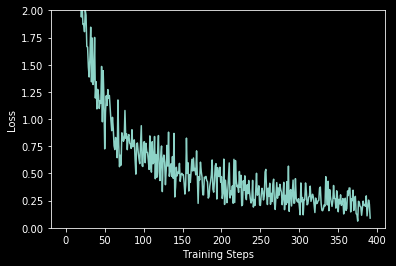

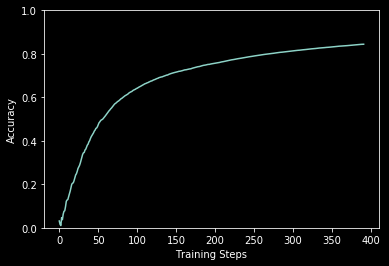

In [9]:
import matplotlib.pylab as plt
plt.style.use('dark_background')

plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats.batch_losses)

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats.batch_acc)


In [10]:
label_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
label_names = np.array([key.title() for key, value in label_names])
label_names

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N',
       'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y'], dtype='<U1')

OSError: Unable to create file (unable to open file: name = './saved_models/h/sign_model.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

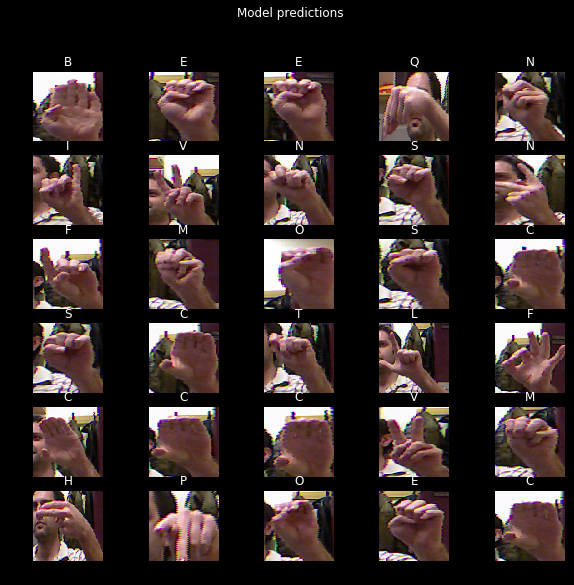

In [19]:
result_batch = model.predict(image_batch)

labels_batch = label_names[np.argmax(result_batch, axis=-1)]


plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(labels_batch[n])
  plt.axis('off')
_ = plt.suptitle("Model predictions")

model.save('./saved_models/h/sign_model.h5')